In [48]:
import pandas as pd
import numpy as np
import pickle as pi
import plotly.express as px
import requests
import itertools
import random

from IPython.display import Image

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors

import pubchempy as pcp

from mp_api.client import MPRester

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('6.csv')

#### Checking for gaps

Let's see how many Nan are in each column

In [7]:
column_names = df.columns.tolist()
for i in range(len(column_names)):
    print(column_names[i], df[column_names[i]].isna().sum())

DOI 0
Date 412
Journal 412
Title 412
Name 5
measurement_error 0
measurement_wavelength 4443
measurement_method 0
normalised_name 1993
raw_value 0
specifier 0


As we can see, the 'Date', 'Journal', and 'Title' columns have gaps, but since this data is not important, they will not be filled in. 

The measurement_wavelength column is practically empty, so it is also supposed to be removed in the future. The main goal at the moment is to fill in the normalised_name column for further unloading of descriptors.

It is important that the target value raw_value has no gaps.

Let's check if there are rows that do not contain data in both Name and normalised_name columns at the same time

In [6]:
# select rows that have no values in the "Name" and "normalised_name" columns at the same time
missing_values = df[(df['Name'].isnull()) & (df['normalised_name'].isnull())]

if len(missing_values) > 0:
    print("There are rows where the 'Name' and 'normalised_name' columns are missing at the same time:")
    print(missing_values)
else:
    print("No rows with missing values in the 'Name' and 'normalised_name' columns at the same time")

No rows with missing values in the 'Name' and 'normalised_name' columns at the same time


#### Filling in gaps in 'Name'

Let's make a list of missing 'Name'.

In [4]:
# selection of row indexes with missing values in the 'Name' column
indexes_null_name = df[df['Name'].isnull()].index.tolist()

# creating a list of values from the Name column by indexes from indexes_null_name
null_name = df.loc[indexes_null_name, 'normalised_name'].tolist()

null_name_list = [[x, y] for x, y in zip(indexes_null_name, null_name)]
print('The number of missing values in the Name:', len(null_name_list))
print(null_name_list)

The number of missing values in the Name: 5
[[3060, 'CC(=C)C1CCC(=CC1)C'], [3065, 'CC(C)O'], [3081, 'CCCCCCCCC'], [3097, 'Nc1ccccc1'], [3136, 'C1CCCCC1']]


Now we can fill gaps in the 'Name' column using null_name_list.

In [7]:
Cactus = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}"

def smiles_to_iupac(smiles): 
    url = Cactus.format(smiles, "iupac_name")
    response = requests.get(url)
    response.raise_for_status()
    return response.text

for i in range(len(null_name_list)):
    iupac_name = smiles_to_iupac(null_name_list[i][1])
    print(iupac_name)
    df.loc[null_name_list[i][0], 'Name'] = iupac_name

1-methyl-4-prop-1-en-2-ylcyclohexene
Propan-2-ol
Nonane
Aniline
Cyclohexane


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         3007 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


Using Cactus, we filled in the gaps in the 'Name' column, now we have all 5000 names.

#### Filling in gaps in 'normalised_name'

Now we can use names of compounds to obtain smiles.

Main idea: using different libraries to get a list of all smiles, then select the most common smiles.

If there are several smiles with the same occurrence, then fill in the cell, for example, "smiles1 or smiles2" and "smiles1 or smiles2 or smiles3".

First of all, let's write a code to print the most common smiles of list.
Keep in mind:
1) that some libraries cannot find smiles, then the list may contain 1 or more items None;
2) some cells already contain smiles, but we are not sure if they were found correctly, so such smiles should also be counted in the list to check their occurrence.

In [30]:
# This example works

# Create a list of items that may occur
elements = [None, 1, 2, 3, 4, 5, 6]

# create a list of all possible combinations of length 6
# max length is 6 (5 libriries + smiles in the cell)
combinations = list(itertools.product(elements, repeat=6))

# choose one random combination from the list
random_combination = random.choice(combinations)

# output the selected random combination
print("\nRandom combination:")
print(random_combination)

# check that the combination contains elements other than None
if all(element is None for element in random_combination):
    print("содержит только элементы со значением None")
else:
#   count the occurrence of each element in the combination
    element_counts = {}
    for element in random_combination:
        if element is not None:
            element_counts[element] = element_counts.get(element, 0) + 1

#   output the most frequently encountered element or elements, if there are several of them
    max_count = max(element_counts.values())
    most_common_elements = [k for k, v in element_counts.items() if v == max_count]
    if len(most_common_elements) == 1:
        print(f"The most common element is: {most_common_elements[0]}")
    else:
        print(f"The most common elements are: {' или '.join(map(str, most_common_elements))}")


Random combination:
(None, 5, None, 5, 1, 1)
The most common elements are: 5 или 1


Now we can use this example to fill 'normalised_name' correctly.

In [ ]:
# When parsing smiles, we learned that different resources can find smiles in different ways, or not at all
# For instance, for PbS can find smiles for PBS compound

# We will use 5 resources to find smiles and select the most popular version of smiles to avoid this problem

# if cell has a smile, we append it in the w8_list_smiles list
for index, row in df.iterrows():
    print('Substance Index:', index)
    if pd.notna(row['normalised_name']):
        w8_list_smiles = []
        w8_list_smiles.append(row['normalised_name'])
    else:
        w8_list_smiles = []
    
#   use PubChem Identifier Exchange Service
    response = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{row["Name"]}/property/CanonicalSMILES/json')
    smiles = None
    if response.status_code == 200:
        try:
            smiles = response.json()['PropertyTable']['Properties'][0]['CanonicalSMILES']
        except:
            pass
        if not smiles:
            try:
                cid = response.json()['PropertyTable']['Properties'][0]['CID']
                compound = pcp.Compound.from_cid(cid)
                smiles = compound.isomeric_smiles
            except:
                pass
        w8_list_smiles.append(smiles)
    
#   use CIRPy
    smiles = None
    try:
        smiles = cirpy.resolve(row['Name'], 'smiles')
    except:
        pass
    w8_list_smiles.append(smiles)
    
#   use ChemSpider
#   enter our API key
    cs = chemspipy.ChemSpider('FrpLnPw0HSVI2v6eyOvPZIM5Aho6YhgL')
    smiles = None
    result = cs.search(row['Name'])
    try:
        smiles = result[0].smiles
    except:
        pass
    w8_list_smiles.append(smiles)

#   use Cactus Chemical Identifier Resolver
    response = requests.get(f'https://cactus.nci.nih.gov/chemical/structure/{row["Name"]}/smiles')
    smiles = None
    if response.status_code == 200:
        try:
            smiles = response.content.decode().strip()
        except:
            pass
    w8_list_smiles.append(smiles)
    
#   use Chembl_webresource_client
    molecule = new_client.molecule
    compound_name = row['Name']
    smiles = None
    try:
        compound = molecule.search(compound_name)[0]
        smiles = compound['molecule_structures']['canonical_smiles']
    except:
        pass
    w8_list_smiles.append(smiles)

#   display the selected combination
    print("A list of smiles that have been found:")
    print(w8_list_smiles)

#   check that the combination contains elements other than None
    if all(element is None for element in w8_list_smiles):
        print("The list contains only None elements")
    else:
#       count the occurrence of each element in the combination
        element_counts = {}
        for element in w8_list_smiles:
            if element is not None:
                element_counts[element] = element_counts.get(element, 0) + 1

#       output the most frequently encountered element or elements, if there are several of them
        max_count = max(element_counts.values())
        most_common_elements = [k for k, v in element_counts.items() if v == max_count]
        if len(most_common_elements) == 1:
            print(f"The most common smiles: {most_common_elements[0]}")
            df.loc[index, 'normalised_name'] = most_common_elements[0]
        else:
            print(f"The most common smiles: {' или '.join(map(str, most_common_elements))}")
            df.loc[index, 'normalised_name'] = ' или '.join(map(str, most_common_elements))
    print()

Due to Internet problems parsing was stopped, to avoid this, we will use the ITMO server.

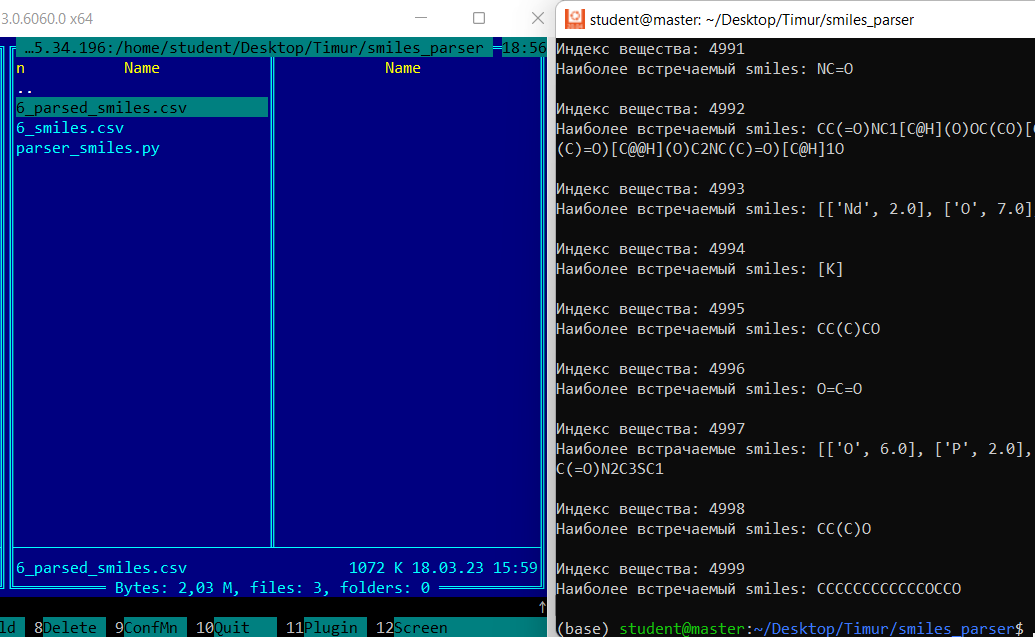

In [32]:
image_path = 'parser_smiles.png'
width = 700
Image(filename=image_path, width=width)

In [41]:
df_parsed = pd.read_csv('6_parsed_smiles.csv')
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         4663 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


After parsing there are 337 gaps in normalised_name.

Let's remove the rows that don't have smiles.

In [42]:
# Delete rows with empty values in the 'normalised_name' column
df_parsed = df_parsed.dropna(subset=['normalised_name'])

# Update indexes
df_parsed = df_parsed.reset_index(drop=True)

We find the number of cells which there are several smiles.

In [43]:
# counting the number of cells containing the word "или" in the "normalised_name" column
count = df_parsed[df_parsed['normalised_name'].str.contains('или', na=False)].shape[0]

print("Number of cells with 'или':", count)

Number of cells with 'или': 417


There are a lot of them to select manually, so we randomly choose one of the values of smiles.

In [46]:
# function to replace a cell with a random smiles from the list
def replace_smile(cell):
    smiles = cell.split(' или ')
    new_smile = random.choice(smiles)
    return new_smile

# ищем ячейки с "или" и заменяем их на случайный смайл из списка
df_str = df_parsed['normalised_name'].str.contains(' или ')
df_parsed.loc[df_str, 'normalised_name'] = df_parsed.loc[df_str, 'normalised_name'].apply(replace_smile)

Count the number of cells containing the word "или" in the 'normalised_name' column.

In [47]:
count = df_parsed[df_parsed['normalised_name'].str.contains('или', na=False)].shape[0]
print("Number of cells with 'или':", count)

Number of cells with 'или': 0


In [ ]:
df_parsed.to_csv('6_good_smiles.csv', index=False)

#### Preprocessing 'raw_value'

After filling in the blanks in normalised_name it is worth processing the target raw_value. The preprocessing will include transformation to numerical format, deletion of outliers, removal of duplicates.

In [79]:
df = pd.read_csv('6_good_smiles.csv')

In [80]:
# set a function to clear the raw value
def clean_value(value):
    new_value = ''
    for s in value:
        if s == '.' and '.' in new_value:
            break
        elif s in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']:
            new_value += s
        elif s in [' ', '-', '±', '–', ';', 'to', '(', '/', '[']:
            break
    return new_value

In [81]:
# apply the function to each element
df['raw_value'] = df['raw_value'].apply(lambda x: clean_value(x))

In [82]:
# convert the raw value column into a numeric format
df['raw_value'] = pd.to_numeric(df['raw_value'], downcast='float')

To see if there are outliers in the raw_value, compare the average value with the maximum and minimum values in the sample.

In [83]:
df.describe()[['raw_value']]

,raw_value
count,4663.000000
mean,1.959614
std,2.361013
min,0.000000
25%,1.407000
50%,1.494140
75%,1.994500
max,104.000000


With the interactive boxplot it is possible to see the outliers.

In [84]:
fig = px.box(df, y=['raw_value'])
fig.show()

In [158]:
image_1 = 'newplot.png'
image_2 = 'box.png'
image_3 = 'hist.png'

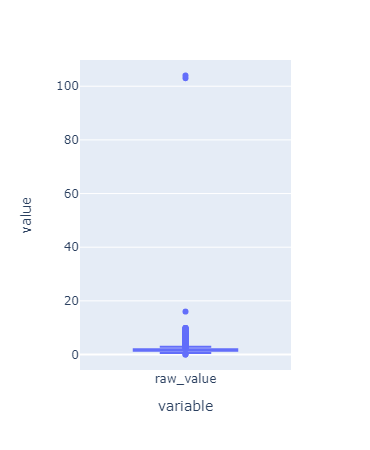

In [159]:
Image(filename=image_1, width=400)

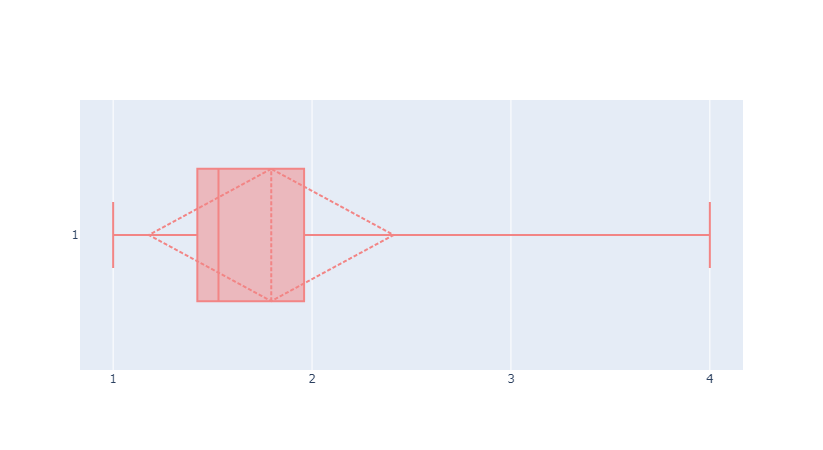

In [161]:
Image(filename=image_2, width=600)

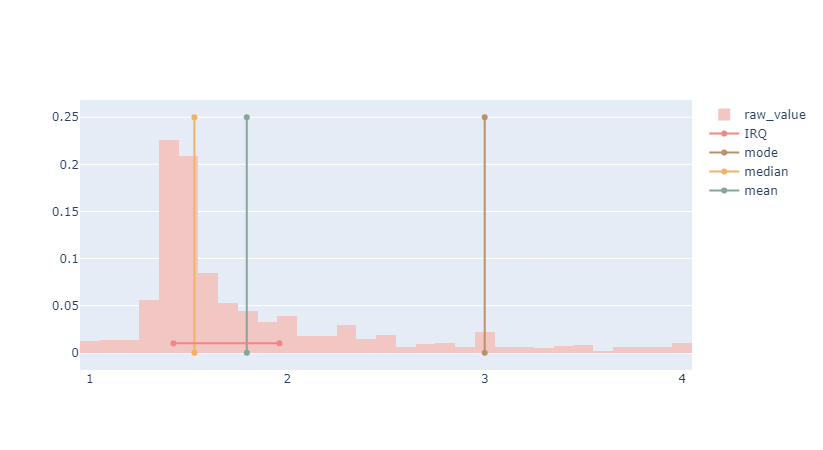

In [162]:
Image(filename=image_3, width=600)

As we see, there are outliers in raw_value, so we remove them. 

Let's define the emission limits from 1 to 4, since these values are the limits for the refractive index. The use of quantiles in this case is unreasonable, because it can lead to the removal of samples with high refractive indices in fact.

In [59]:
lower_bound = 1
upper_bound = 4

In [60]:
# remove everything outside the raw_value boundary
df = df[(df['raw_value'] >= lower_bound) & (df['raw_value'] <= upper_bound)]

In [61]:
# remove lines in which the error of measurement exceeds the median value
df = df[df['measurement_error'] <= df['raw_value'].median()]

In [62]:
df.describe()[['raw_value']]

,raw_value
count,4428.000000
mean,1.731461
std,0.582302
min,1.000000
25%,1.401000
50%,1.488200
75%,1.840500
max,4.000000


As we can see, the removal of the outliers was successful.

Now it is necessary to remove the duplicate smiles. To do this, group the dataframe by 'normalised_name' and 'measurement_method'. 

In [63]:
# find the number of unique smiles
len(pd.unique(df['normalised_name']).tolist())

1334

In [64]:
# grouped by smiles and method of measurement
df_group = df.groupby(['normalised_name', 'measurement_method'], group_keys=True).apply(lambda x: x)

After grouping, it is necessary to find a string for each unique smiles that is closest to the median value of 'raw_value' and corresponds to the most frequent 'measurement_method'

In [65]:
# let's introduce a function that looks for the closest value to the values from the sheet
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  
  return arr[i]

In [66]:
# let's select one line for each smiles according to the principle of closeness of the raw value to the median value for this substance among the most frequent methods of measurement
df_result = pd.DataFrame()
unique_smiles = pd.unique(df['normalised_name']).tolist()

for smiles in unique_smiles:
    common_metod = df_group.loc[smiles]['measurement_method'].value_counts().idxmax()
    val = closest_value(list(df_group.loc[smiles, common_metod]['raw_value']), df_group.loc[smiles, common_metod]['raw_value'].median())
    row = df[(df['normalised_name'] == smiles) & (df['raw_value'] == val) & (df['measurement_method'] == common_metod)]

    df_result = df_result.append(row.iloc[0])

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4557/3056076652.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

After getting a dataset without duplicates, let's delete the columns we don't need in the future

In [67]:
df_result_clear = df_result.drop(columns=['DOI', 'Date', 'Journal', 'Title', 'measurement_error',
       'measurement_wavelength', 'specifier'])

Transform 'normalised_name' into mol files to further search for descriptors for those smiles for which it is possible

In [68]:
mols = [Chem.MolFromSmiles(smi) for smi in df_result_clear['normalised_name'].tolist()]
df_result_clear['mol_file'] = mols

[14:45:16] SMILES Parse Error: syntax error while parsing: [['As',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['As',' for input: '[['As','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['Er',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['Er',' for input: '[['Er','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['Li',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['Li',' for input: '[['Li','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['As',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['As',' for input: '[['As','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['Cu',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['Cu',' for input: '[['Cu','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['He',
[14:45:16] SMILES Parse Error: Failed parsing SMILES '[['He',' for input: '[['He','
[14:45:16] SMILES Parse Error: syntax error while parsing: [['Ba',
[14:45:16] SMILES Parse Err

In [69]:
# the number of smiles for which no mol file was found
len(df_result_clear.loc[df_result_clear['mol_file'].isna()])

427

#### Downloading descriptors

**Mordred**

In [30]:
# set the descriptor calculator
calc = Calculator(descriptors, ignore_3D=True)

In [31]:
# number of descriptors without using 3d descriptors, i.e. atomic coordinates
len(calc.descriptors)

1613

In [34]:
# split the dataframe into parts that contain mol file and None
df_nans = df_result_clear.loc[df_result_clear.mol_file.isna()]
df_yes = df_result_clear.loc[df_result_clear.mol_file.notna()]

In [ ]:
# unload the descriptors for the dataframe that contains the mol file
df_molecular_desc = calc.pandas(df_yes['mol_file'])

In [36]:
# merge dataframes
df_with_desc = pd.concat([df_yes, df_molecular_desc], axis=1)
df_result = pd.concat([df_with_desc, df_nans])

In [37]:
# save the descriptors in csv
df_result.to_csv('db_descriptors_Mordred.csv', index=False)

**RDKit**

In [42]:
# set the descriptor calculator
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

In [43]:
# number of descriptors
print(len(Descriptors._descList))

208


In [44]:
# descriptor names
desc_names = calc.GetDescriptorNames()

In [ ]:
# unload the descriptors and create a dataframe
mol_descriptors = []

for mol in df_yes['mol_file']:
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

df_molecular_desc = pd.DataFrame(mol_descriptors, columns=desc_names)

In [47]:
# merge dataframes
df_with_desc = pd.concat([df_yes.reset_index(drop=True), df_molecular_desc], axis=1)
df_result = pd.concat([df_with_desc, df_nans.reset_index(drop=True)])

In [59]:
# save the descriptors in csv
df_result.to_csv('db_descriptors_RDKit.csv', index=False)

**PubChem**

In [50]:
# set properties for unloading
properties = ['MolecularFormula', 'MolecularWeight','InChI', 'InChIKey', 'IUPACName', 
                                'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 
                                'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 
                                'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 
                                'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 
                                'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount', 
                                'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 
                                'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D', 
                                'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 
                                'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D', 
                                'EffectiveRotorCount3D', 'ConformerCount3D']

In [51]:
# number of descriptors
len(properties)

37

In [53]:
# set an empty dictionary for undetected smiles
nans_dict = {}
for p in properties:
    nans_dict[p] = np.nan

In [ ]:
# unload the descriptors
data = []

for i in df['normalised_name']:
    try:
        props = pcp.get_properties(properties, i, 'smiles')
        data.append(props)
    except:
        
        data.append([nans_dict])

In [ ]:
# transfer the data to a dataframe
rows = []
columns = data[1][0].keys()
for i in range(len(df['normalised_name'])):
    rows.append(data[i][0].values())
props_df = pd.DataFrame(data=rows, columns=columns) 

In [ ]:
# merge dataframes
df_result = pd.concat([df, props_df], axis=1)

In [ ]:
# save the descriptors in csv
df_result.to_csv('db_descriptors_PubChem.csv', index=False)

**Materials Project**

In [72]:
# find the number of descriptors in MP
MP_API_KEY = "d2mK9UPMEmGUfNpiFEf8gSwE6De4XX2i"

with MPRester(MP_API_KEY) as mpr:
    print('Number of descriptors:', len(mpr.summary.available_fields))
    print()
    print(mpr.summary.available_fields)
    list_fields = mpr.summary.available_fields

Number of descriptors: 73

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_anisotropy', 'hom

Let's try one example and select descriptors that can be added to a dataset.

In [70]:
data = mpr.get_entries('K2O')[0]
material_id = data.data["material_id"]
materials = mpr.summary.search(material_ids=[material_id])
material = materials[0]

Retrieving ThermoDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [74]:
for field in list_fields:
    print(field, 'feature')
    print(getattr(material, field))

builder_meta feature
emmet_version='0.38.6' pymatgen_version='2022.10.22' pull_request=825 database_version='2022.10.28' build_date=datetime.datetime(2022, 10, 28, 0, 55, 23, 76000)
nsites feature
6
elements feature
[Element K, Element O]
nelements feature
2
composition feature
K4 O2
composition_reduced feature
K2 O1
formula_pretty feature
K2O
formula_anonymous feature
AB2
chemsys feature
K-O
volume feature
175.829935846865
density feature
1.779175282799177
density_atomic feature
29.304989307810832
symmetry feature
crystal_system=<CrystalSystem.tet: 'Tetragonal'> symbol='I4_1/amd' number=141 point_group='4/mmm' symprec=0.1 version='1.16.2'
property_name feature
summary
material_id feature
mp-936219
deprecated feature
False
deprecation_reasons feature
None
last_updated feature
2022-10-28 00:55:23.076000
origins feature
[]
warnings feature
[]
structure feature
Full Formula (K4 O2)
Reduced Formula: K2O
abc   :   7.291465  10.450410   7.512395
angles:  27.674687  61.657817  46.358168
pbc  

In [76]:
# selecting descriptors
good_list_fields = ['nsites', 'volume', 'density', 'density_atomic', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy', 'weighted_work_function', 'surface_anisotropy', 'shape_factor', 'has_reconstructed', 'theoretical']
print('Number of descriptors:', len(good_list_fields))

Number of descriptors: 47


Let's find descriptors for all chemical compounds.

In [78]:
# create new columns in the dataframe
for column_name in good_list_fields:
    df_result_clear[column_name] = None

In [ ]:
w8_list_MP = []
for i in range(len(df['Name'].tolist())):
    try:
        data = mpr.get_entries(df['Name'].tolist()[i])[0]
        material_id = data.data["material_id"]
        materials = mpr.summary.search(material_ids=[material_id])
        material = materials[0]
        for field in good_list_fields:
            w8_list_MP.append(getattr(material, field))
#       iterate over column names and corresponding values
        for col, val in zip(good_list_fields, w8_list_MP):
#           adding a value to a specific row and column
            df.loc[i, col] = val
    except:
        pass

In [ ]:
df.to_csv('db_descriptors_MaterialsProject.csv', index=False)

#### Merging datasets

After unloading all the descriptors it is necessary to merge the dataframes

In [125]:
# load datasets of descriptors
df_mordred = pd.read_csv('db_descriptors_Mordred.csv')
df_rdkit = pd.read_csv('db_descriptors_RDKit.csv')
df_pubchem = pd.read_csv('db_descriptors_PubChem.csv')
df_matproj = pd.read_csv('db_descriptors_MaterialsProject.csv')

/tmp/ipykernel_4557/4257715012.py:2: DtypeWarning:

Columns (8,9,10,11,12,13,14,15,16,17,18,19,57,58,59,60,61,62,63,64,65,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,139,140,141,142,143,144,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,166,167,168,169,170,171,172,173,175,176,177,178,179,180,181,182,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,264,265,266,267,268,269,270,271,272,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,345,346,347,348,349,350,351,352,353,355,356,357,358,359,360,361,362,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,382,383,384,385,386,387,388,389,391,392,393,394,395,396,397,398,400,401,402,403,404,405,406,4

In [126]:
# replace all string values with nans and make sure that all elements are in numeric format
for df in [df_mordred, df_rdkit, df_pubchem, df_matproj]:
    columns = df.columns.tolist()

    for column in columns[4:]:
        new_column = pd.to_numeric(df[column], errors='coerce')
        df[column] = new_column

In [127]:
# sort the values within the dataframes and make sure that the rows are in the same places
df_mordred_sorted = df_mordred.sort_values(by=['raw_value', 'normalised_name']).reset_index(drop=True)
df_rdkit_sorted = df_rdkit.sort_values(by=['raw_value', 'normalised_name']).reset_index(drop=True)
df_pubchem_sorted = df_pubchem.sort_values(by=['raw_value', 'normalised_name']).reset_index(drop=True)
df_matproj_sorted = df_matproj.sort_values(by=['raw_value', 'normalised_name']).reset_index(drop=True)

test = []
for df_1 in [df_mordred_sorted, df_rdkit_sorted, df_pubchem_sorted, df_matproj_sorted]:
    for df_2 in [df_mordred_sorted, df_rdkit_sorted, df_pubchem_sorted, df_matproj_sorted]:
        test.append(df_1['normalised_name'].equals(df_2['normalised_name']))

if False not in test:
    print('Dataframes are sorted the same way!')

Dataframes are sorted the same way!


In [128]:
# merge dataframes
df = pd.concat([df_mordred_sorted.iloc[:, 1:], df_rdkit_sorted.iloc[:, 4:], df_pubchem_sorted.iloc[:, 10:], df_matproj_sorted.iloc[:, 4:]], axis=1)

In [129]:
# check the shape of the dataframe
df.shape

(1334, 1903)

#### Removing empty columns and rows

In [130]:
# remove columns and rows that consist entirely of NaN (thresh = 4 - something other than 'raw vallue', 'normalised_name', 'measurement_method' is filled)
df = df.dropna(axis = 1, how='all')
df = df.dropna(axis = 0, thresh=4)
df.shape

(1071, 1811)

In [131]:
# remove the duplicate columns
df_no_duplicates = df.T.drop_duplicates().T
df_no_duplicates = df_no_duplicates.iloc[:, ~ df_no_duplicates.columns.duplicated()]
df_no_duplicates.shape

(1071, 1583)

In [132]:
# find the columns that have more than 30% nan and delete them from the dataview
drop_list = []

for column in df_no_duplicates.columns:
    count_nan = df_no_duplicates[column].isnull().sum().astype(int)

    if count_nan >= len(df_no_duplicates)*0.30:
        drop_list.append(column)

print('Number of columns to be deleted:', len(drop_list))

Number of columns to be deleted: 461


In [133]:
# filter out the low-dispersion descriptors
variances = []

for col in df_no_duplicates.iloc[:, 3:].columns:
    try:
      var = df_no_duplicates[col].var(ddof=1)
      variances.append((col, var))
    except:
      continue

for col, var in variances:
  if var <= 0.01:
    drop_list.append(col)

df_result = df_no_duplicates.drop(drop_list, axis=1)

print('The total size of the dataframe:', df_result.shape)

The total size of the dataframe: (1071, 1038)


#### Filling in gaps in the descriptors

In [134]:
# set the part of the dataframe where you want to fill nans
X = df_result.iloc[:, 3:]

In [135]:
# because of the error arising with the presence of infinite values, we apply the function
X.replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_4557/3790214072.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
# number of nans
pd.DataFrame(X).isnull().sum().sum()

209332

In [137]:
# define imputer
imputer = KNNImputer()

# fit on the dataset
imputer.fit(X)

# transform the dataset
Xtrans = imputer.transform(X)

/home/tr_rakhmanov/miniconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:478: RuntimeWarning:

overflow encountered in multiply

/home/tr_rakhmanov/miniconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:480: RuntimeWarning:

invalid value encountered in subtract



In [138]:
# translate to dataframe
X_result = pd.DataFrame(Xtrans, columns=X.columns)

In [139]:
# number of nans after filling
X_result.isnull().sum().sum()

0

In [140]:
# save the data
X_result.insert(0, "measurement_method", df_result["measurement_method"].reset_index(drop=True), True)
X_result.insert(0, "raw_value", df_result["raw_value"].reset_index(drop=True), True)
X_result.insert(0, "normalised_name", df_result["normalised_name"].reset_index(drop=True), True)

X_result.to_csv('6_clear.csv', index=False)

In [141]:
X_result = X_result.drop(['raw_value', 'normalised_name', 'measurement_method'], axis=1)

#### Normalization

To further work with the data, a normalized dataframe comes in useful

In [142]:
# let's set the scaler
scaler = MinMaxScaler()

In [149]:
# then apply it to the dataset
scaler.fit(X_result)

MinMaxScaler()

In [150]:
# let's save the scaler
pi.dump(scaler, open('scaler.pkl', 'wb'))

In [151]:
# transforming existing data
X_result_transform = scaler.transform(X_result)

In [152]:
# return the 'raw_value' to the dataframe
X_result_transform = pd.DataFrame(X_result_transform, columns=X.columns)
X_result_transform.insert(0, "raw_value", df_result["raw_value"].reset_index(drop=True), True)

In [153]:
# save the normalized data obtained
X_result_transform.to_csv('6_clear_normalised.csv', index=False)